In [1]:
import pandas as pd
import zipfile
from langdetect import detect
import warnings
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
warnings.filterwarnings("ignore")


# Load data

In [7]:
z = zipfile.ZipFile('./data/airbnb/airbnb.zip', 'r')
z.extract("reviews.csv", "./data/airbnb/")
z = zipfile.ZipFile('./data/hotel-reviews-eu/515k-hotel-reviews-data-in-europe.zip', 'r')
z.extractall("./data/hotel-reviews-eu/")
z = zipfile.ZipFile('./data/hotel-reviews/hotel-reviews.zip', 'r')
z.extractall("./data/hotel-reviews/")

# Explore Airbnb reviews

In [19]:
airbnb_data = pd.read_csv('./data/airbnb/reviews.csv')
print('Null reviews:', sum(airbnb_data.comments.isna()))

Null reviews: 622


In [25]:
airbnb_data = airbnb_data.dropna(subset=['comments'])

In [22]:
airbnb_data.comments.describe()

count                                               1485614
unique                                              1426862
top       The host canceled this reservation 2 days befo...
freq                                                   1646
Name: comments, dtype: object

In [53]:
airbnb_data = airbnb_data.drop_duplicates(subset=['comments'])
airbnb_data['text_length'] = airbnb_data.comments.apply(len)

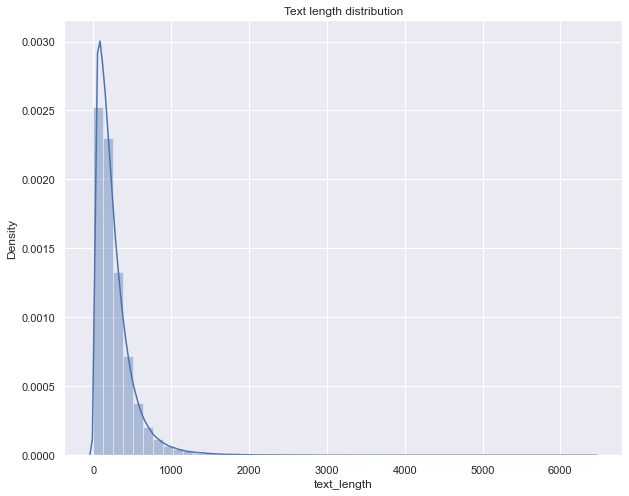

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme();


fig, ax = plt.subplots(figsize=(10,8))
chart = sns.distplot(airbnb_data['text_length'])
ax.set_title("Text length distribution")
plt.show();

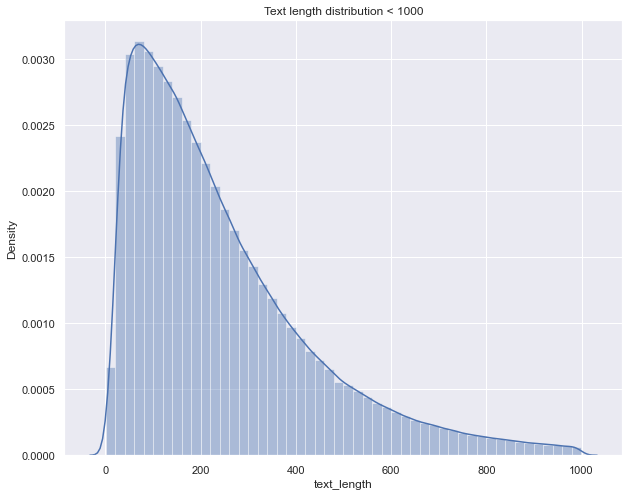

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
chart = sns.distplot(airbnb_data['text_length'][airbnb_data['text_length'] < 1000])
ax.set_title("Text length distribution < 1000")
plt.show();

In [66]:
airbnb_data = airbnb_data[airbnb_data.text_length > 10]

In [ ]:
airbnb_data['predict_lang'] = airbnb_data.comments.apply(detect)
print('Unique langs: \n', airbnb_data['predict_lang']).unique())

# Explore Hotel reviews data

In [3]:
hotel_data = pd.read_csv('./data/hotel-reviews/Datafiniti_Hotel_Reviews.csv')

In [5]:
hotel_data.columns

Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites'],
      dtype='object')

In [10]:
hotel_data_eu = pd.read_csv('./data/hotel-reviews-eu/Hotel_Reviews.csv')
hotel_data_eu.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [12]:
hotel_data_eu.head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968


In [23]:
positive_texts = hotel_data_eu['Positive_Review'].tolist()
negative_texts = hotel_data_eu['Negative_Review'].tolist()
positive_labels = [1 for i in range(len(positive_texts))]
negative_labels = [0 for i in range(len(negative_texts))]

sentiment_data = pd.DataFrame({'text': positive_texts + negative_texts, 'sentiment': positive_labels + negative_labels})
sentiment_data.dropna(subset=['text'], inplace=True)
sentiment_data['text'] = sentiment_data['text'].astype('str')
sentiment_data['text_length'] = sentiment_data.text.apply(len)
sentiment_data = sentiment_data.sample(frac=1).reset_index(drop=True)

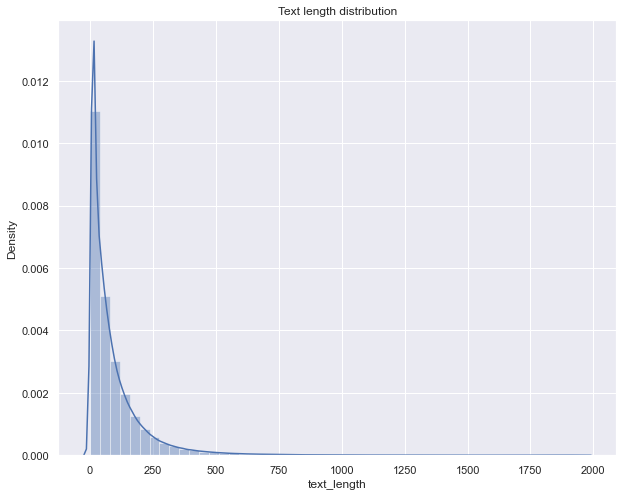

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
chart = sns.distplot(sentiment_data['text_length'])
ax.set_title("Text length distribution")
plt.show();

In [26]:
sentiment_data = sentiment_data[(sentiment_data['text_length'] < 500) &  (sentiment_data['text_length'] > 10)]

# Get sentiment with Vader Sentiment

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiment_data['score'] = sentiment_data.text.apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [39]:
from sklearn.metrics import classification_report

In [41]:
print(classification_report(sentiment_data['sentiment'], 
                            (sentiment_data['score'] > 0).astype('int')))

              precision    recall  f1-score   support

           0       0.71      0.51      0.60    468948
           1       0.63      0.80      0.70    486690

    accuracy                           0.66    955638
   macro avg       0.67      0.66      0.65    955638
weighted avg       0.67      0.66      0.65    955638



# Text preprocessing and analyzing

In [42]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [54]:
doc = nlp('This was the best played game')
[(token.lemma_, token.pos_) for token in doc]

[('this', 'DET'),
 ('be', 'AUX'),
 ('the', 'DET'),
 ('well', 'ADV'),
 ('play', 'VERB'),
 ('game', 'NOUN')]

In [51]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer

tokenizer = TweetTokenizer()
stemmer = SnowballStemmer('english')

In [67]:
import re

text = 'This was the best played game'
tokens = tokenizer.tokenize(text)
tokens1 = text.split(' ')
tokens2 = re.findall('\w+', text)
tokens == tokens1 == tokens2

True

In [68]:
tokens

['This', 'was', 'the', 'best', 'played', 'game']

In [69]:
stemmed_tokens = [stemmer.stem(w) for w in tokens]
stemmed_tokens

['this', 'was', 'the', 'best', 'play', 'game']

In [71]:
def preprocess_text(text):
    tokens = tokenizer.tokenize(text.lower())
    return [stemmer.stem(w) for w in tokens]

In [73]:
sentiment_data['tokens'] = sentiment_data.text.apply(preprocess_text)

In [75]:
all_counts = {}
positive_counts = {}
negative_counts = {}
for i, row in sentiment_data.iterrows():
    for token in row.tokens:
        if token not in all_counts:
            all_counts[token] = 1
        else:
            all_counts[token] += 1
        if row.sentiment:
            if token not in positive_counts:
                positive_counts[token] = 1
            else:
                positive_counts[token] += 1
        else:
            if token not in negative_counts:
                negative_counts[token] = 1
            else:
                negative_counts[token] += 1

In [78]:
print('50 most common tokens: \n', sorted(all_counts, key=lambda x: all_counts.get(x), reverse=True)[:50])

50 most common tokens: 
 ['the', 'and', 'was', 'room', 'to', 'a', 'veri', 'in', 'no', 'staff', 'locat', 'of', 'hotel', 'for', 'is', 'it', 'i', 'breakfast', 'were', 'negat', 'we', 'good', 'not', 'great', 'with', 'bed', 'friend', 'but', 'help', 'on', 'clean', 'at', 'nice', 't', 'from', 'comfort', 'had', 'have', 'excel', 'stay', 'be', 'that', 'small', 'you', 'as', 'so', 'there', 'love', 'all', 'are']


In [79]:
print('50 most common tokens in positive: \n', sorted(positive_counts, key=lambda x: positive_counts.get(x), reverse=True)[:50])

50 most common tokens in positive: 
 ['the', 'and', 'was', 'staff', 'locat', 'veri', 'room', 'to', 'a', 'hotel', 'good', 'great', 'in', 'of', 'is', 'friend', 'were', 'breakfast', 'help', 'for', 'nice', 'clean', 'comfort', 'bed', 'excel', 'with', 'we', 'it', 'i', 'love', 'no', 'posit', 'stay', 'from', 'at', 'close', 'on', 'station', 'all', 'walk', 'are', 'but', 'our', 'perfect', 'realli', 'servic', 'you', 'everyth', 'restaur', 'so']


In [80]:
print('50 most common tokens in negative: \n', sorted(negative_counts, key=lambda x: negative_counts.get(x), reverse=True)[:50])

50 most common tokens in negative: 
 ['the', 'was', 'no', 'a', 'room', 'to', 'and', 'in', 'negat', 'not', 'of', 'for', 'it', 'i', 'veri', 'we', 'is', 'but', 'hotel', 't', 'on', 'breakfast', 'have', 'at', 'were', 'small', 'had', 'be', 'that', 'with', 'there', 'as', 'from', 'bed', 'staff', 'you', 'so', 'they', 'could', 'my', 'this', 'too', 'bit', 'would', 'our', 'bathroom', 'are', 'onli', 'night', 'all']


In [81]:
pos_token_probability = {token: positive_counts[token] / all_counts[token] for token in positive_counts}
print('50 most probable tokens in positive: \n', sorted(pos_token_probability, key=lambda x: pos_token_probability.get(x), reverse=True)[:50])

50 most probable tokens in positive: 
 ['aniko', 'spearmint', 'winemak', 'seemless', 'locstion', 'kike', 'floorwarm', 'atmosf', 'carolina', 'cnr', 'phil', 'foosbal', 'babyfoot', 'drinkl', 'excelsnt', 'universitat', 'rampla', 'zoe', 'urquiola', 'hani', 'exepri', '06h40', 'boi', 'bolong', 'westbahnhoff', 'recommendatiion', 'keft', '3teabag', 'sergi', 'meia', 'cerverseria', 'catalana', 'stephansplaz', 'ahom', 'detfin', 'stylis', 'chani', 'famtast', 'liliya', 'palladium', 'locationi', 'pompidou', 'everythijf', 'gerard', 'pleasnt', 'bargin', 'identikit', 'orienr', 'fatast', 'mauric']


In [84]:
pos_token_probability = {token: prob for token, prob in pos_token_probability.items() if prob < 0.9}
print('50 most probable tokens in positive: \n', sorted(pos_token_probability, key=lambda x: pos_token_probability.get(x), reverse=True)[:50])

50 most probable tokens in positive: 
 ['baker', 'chic', 'stadium', 'dome', 'embassi', 'sleek', 'galleria', 'wembley', 'pleasant', 'tremend', 'proffession', 'comfiest', 'waitros', 'emplac', 'sizabl', 'blvd', 'piazza', 'julia', 'leo', 'polo', 'latino', 'vincent', 'swanki', 'tidi', 'effici', 'olymp', 'repubblica', 'conscienti', 'vineyard', 'cadorna', 'madelin', '57th', 'christoph', 'bespok', 'hardwork', 'chris', 'kew', 'hungarian', 'mike', 'coveni', 'vanessa', 'handwritten', 'silent', 'gard', 'seamless', 'bush', 'spectacular', 'las', 'rambla', 'tottenham']


In [86]:
neg_token_probability = {token: negative_counts[token] / all_counts[token] for token in negative_counts}
neg_token_probability = {token: prob for token, prob in neg_token_probability.items() if prob < 0.9}
print('50 most probable tokens in negative: \n', sorted(neg_token_probability, key=lambda x: neg_token_probability.get(x), reverse=True)[:50])

50 most probable tokens in negative: 
 ['tight', 'apolog', 'prevent', 'frame', 'concret', 'appar', 'sex', 'fray', 'indic', 'mug', 'neither', 'wast', 'earplug', 'dark', '170', 'tear', 'fatti', 'switch', 'should', 'bug', 'hook', 'unblock', 'disgrac', '209', 'softer', 'abit', 'paint', 'wateri', 'forc', 'tile', 'corridor', 'unless', 'interv', 'smokey', 'recess', 'pinch', 'insist', 'neck', 'scari', 'flow', 'neighbor', 'dissapoint', 'pointless', 'stool', 'manoeuvr', 'unhappi', 'net', 'stench', 'tooooo', 'spg']


# Model training

In [89]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(sentiment_data['tokens'].apply(' '.join), sentiment_data['sentiment'], test_size=0.2)

In [133]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(analyzer='word', ngram_range=(1,1), max_features=15000, max_df=0.8, min_df=2)
vec.fit(train_texts)
X_train = vec.transform(train_texts)
X_test = vec.transform(test_texts)

In [113]:
vec.vocabulary_

{'the': 13212,
 'room': 11157,
 'are': 1634,
 'spacious': 12241,
 'and': 1454,
 'clean': 3435,
 'concept': 3736,
 'is': 7306,
 'well': 14561,
 'thought': 13291,
 'off': 9277,
 'make': 8215,
 'sens': 11599,
 'breakfast': 2609,
 'was': 14479,
 'realli': 10639,
 'nice': 9045,
 'lot': 8042,
 'of': 9274,
 'option': 9379,
 'no': 9095,
 'negat': 8975,
 'there': 13240,
 'swim': 12916,
 'pool': 10039,
 'might': 8541,
 'be': 2088,
 'bit': 2349,
 'picki': 9868,
 'but': 2800,
 'long': 8018,
 'curtain': 4156,
 'in': 7043,
 'our': 9430,
 'didn': 4490,
 'reach': 10620,
 'floor': 5730,
 'after': 1142,
 'night': 9068,
 'sun': 12774,
 'came': 2862,
 'to': 13393,
 'earli': 4904,
 'veri': 14267,
 'good': 6265,
 'locat': 7975,
 'love': 8067,
 'not': 9155,
 'great': 6359,
 'ground': 6404,
 'with': 14758,
 'singl': 11905,
 'bed': 2138,
 'right': 11051,
 'by': 2816,
 'recept': 10686,
 'grade': 6311,
 'on': 9334,
 'websit': 14535,
 'could': 3960,
 'mirror': 8613,
 'those': 13287,
 'book': 2478,
 'com': 3605,
 

In [103]:
train_texts.values[0]

'the room are spacious and clean the concept is well thought off and make sens breakfast was realli nice a lot of option'

In [107]:
text_features = X_train[0].toarray()[0]
text_features

array([0., 0., 0., ..., 0., 0., 0.])

In [108]:
text_features[13212] # TF-IDF of "the"

0.1707919025712586

In [117]:
import numpy as np 


ind2tokens = {ind: token for token, ind in vec.vocabulary_.items()}
important_token_inds = np.argsort(text_features)[::-1][:3]
print('Most important features in text: \n', [ind2tokens[i] for i in important_token_inds])

Most important features in text: 
 ['sens', 'concept', 'thought']


In [119]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, solver='sag')
model.fit(X_train, train_labels)

LogisticRegression(C=0.1, solver='sag')

In [120]:
preds = model.predict(X_text)
print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     93971
           1       0.96      0.94      0.95     97157

    accuracy                           0.95    191128
   macro avg       0.95      0.95      0.95    191128
weighted avg       0.95      0.95      0.95    191128



In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rnf = RandomForestClassifier(n_estimators=100)
rnf.fit(X_train, train_labels)

RandomForestClassifier()

In [137]:
preds = rnf.predict(X_test)
f1_score(test_labels, preds)

0.9543551219309456

In [128]:
feature_importance = rnf.feature_importances_
most_important = feature_importance.argsort()[::-1][:10]

[(ind2tokens[ind], feature_importance[ind]) for ind in most_important]

[('locat', 0.06470771689352102),
 ('no', 0.05689386084456882),
 ('negat', 0.04969778235215275),
 ('staff', 0.040379307095982975),
 ('posit', 0.03332228880617413),
 ('and', 0.02527387615849944),
 ('great', 0.023452675743914356),
 ('not', 0.022763585397215125),
 ('good', 0.019292335329754596),
 ('friend', 0.017434655316712268)]

In [136]:

best_score = 0
for tol in [1e-2, 1e-3, 1e-4]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        for solver in ['sag', 'liblinear', 'lbfgs']:
            logreg = LogisticRegression(C=C, tol=tol, solver=solver)
            logreg.fit(X_train, train_labels)
            preds = logreg.predict(X_test)
            f1 = f1_score(test_labels, preds)
            # if we got a better score, store the score and parameters
            if f1 > best_score:
                best_score = f1
                best_parameters = logreg.get_params()

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Best score: 0.95
Best parameters: {'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.001, 'verbose': 0, 'warm_start': False}
